In [1]:
############################################################################
#  Funtions to create maps of the Mackenzie River
############################################################################
# -------------------------------------------------------------------------
# 1. plot_arctic_mackenzie_azimuthal_regional_Sref
# 2. plot_arctic_mackenzie_azimuthal_regional
# 3. plot_arctic_mackenzie_azimuthal_Sref
# 4. plot_arctic_mackenzie_azimuthal
# 5. plot_arctic_mackenzie_azimuthal_poly_BG
# 6. plot_arctic_mackenzie_azimuthal_poly_BG_c
# -------------------------------------------------------------------------
# Author    : Maria Sanchez Urrea
# Email     : maria.sanchez.urrea@gmail.com
# Creation  : December 2022
############################################################################

import xarray as xr
import numpy as np

import metpy
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import regionmask  # to create a mask
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from matplotlib_scalebar.scalebar import ScaleBar
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cmocean import cm
import calendar

# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1) Manage the land polygons for plots:
resolution = '10m' # 10m 50m 110m

land_poly = cfeature.NaturalEarthFeature(category='physical',
                                         name='land',
                                         scale=resolution,
                                         edgecolor='#3b3b3b',
                                         facecolor='#b3b3b3',
                                         linewidth=0.5)
                                         #facecolor=cfeature.COLORS['land'])

rivers = cfeature.NaturalEarthFeature(category='physical',
                                      name='rivers_lake_centerlines',
                                      scale=resolution,
                                      facecolor='none', edgecolor='#3b3b3b',
                                      linewidth=0.3)

lakes = cfeature.NaturalEarthFeature(category='physical',
                                      name='lakes',
                                      scale=resolution,
                                      facecolor='w', edgecolor='#3b3b3b',
                                      linewidth=0.3)
# 2) Others:

#plt.rcParams["font.family"] = "serif"
mono_font = {'fontname':'monospace'} # for title


In [3]:
############################################################################
# 1. Plot Mackenzie River EASEGrid v2 (Zoom in the Mackenzie River)
############################################################################

def plot_arctic_mackenzie_azimuthal_regional_Sref(darray, ptitle, ctitle, minl, maxl, cmap=cm.haline_r, blevels=None, clines=False, clevels=None, fs=12):
    '''
    Plot Sea Surface Salinity (SSS) centered in the Mackenzie River.
    Countour line of Sr (Reference Salinity) in red.
    Sref = 26 countour line is plotted in red.
    Admits: EASEGrid (LambertAzimuthalEqualArea) and WGS84 projections.

    Args:
      darray (xarray.DataArray): SSS data (monthly or daily)
      ptitle(str)              : main title for plot
      ctitle(str)              : label for cbar
      minl(integer)            : minimun value for plotting
      maxl(integer)            : maximun value for plotting
      cmap                     : colour palette (cm.haline_r by default)
      blevels (list)           : tick marks on the colorbar (22,34,2 by default)
      clines(bool)             : contour lines (False by default)
      clevels (list)           : contour levels (22,34,2 by default)
      fs (integer)             : fontsize (12 by default)

    '''

    # Select Map Area (Mackenzie River)
    latN = 72.2
    latS = 68.2
    lonW = -140
    lonE = -129

    # Original Projection of the data and central lat/lon
    projection = ccrs.LambertAzimuthalEqualArea(central_longitude=-135,central_latitude=70.5)

    # Plot extension
    fig, ax = plt.subplots(1,1, figsize=(9,9),subplot_kw=dict(projection=projection))
    ax.set_extent([lonW, lonE, latS, latN],crs=ccrs.PlateCarree())

    # Coastlines and land polygons:
    #ax.coastlines()
    ax.add_feature(land_poly, zorder=1)
    ax.add_feature(rivers, zorder=2)
    ax.add_feature(lakes, zorder=2)

    # Gridlines:
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='#343a40',
                      alpha=0.5, linestyle='--',
                      transform=ccrs.PlateCarree(),
                      zorder=2)

    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator([-139, -136, -133, -130])
    gl.ylocator = mticker.FixedLocator([68, 69, 70, 71, 72])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': fs, 'color': '#545454', 'weight': 'normal'}
    gl.ylabel_style = {'size': fs, 'color': '#545454', 'weight': 'normal'}

    # Plot the data:
    im = ax.pcolormesh(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                       vmin=minl,vmax=maxl,
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       zorder=0)

    if not clevels:
        clevels = [22, 24, 26, 28, 30, 32, 34]

    if clines:
        line_c = ax.contour(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                            levels=clevels,
                            linewidths=[0.3, 0.3, 0.7, 0.3, 0.3, 0.3, 0.3],
                            colors=['black','black','red','black','black','black','black'],
                            alpha=1, linestyles='-',
                            transform=ccrs.PlateCarree())

        ax.clabel(line_c,  # Typically best results when labelling line contours
                  colors=['black'],
                  manual=False,  # Automatic placement vs manual placement
                  inline=True,   # Cut the line where the label will be placed
                  fmt=' {:.0f} '.format,
                  fontsize=fs-4)

    # Add the colorbar
    if not blevels:
        blevels = [22, 24, 26, 28, 30, 32, 34]

    cbar = fig.colorbar(im, ax=ax,
                        fraction=0.03, pad=0.06,
                        orientation='horizontal',
                        extend='both',
                        ticks=blevels)
    cbar.set_label(ctitle, fontsize=fs+4)

    # Add the title
    plt.title(ptitle, fontsize=fs+6, fontweight='bold', **mono_font)

    # ScaleBar
    scale = ScaleBar(dx=1,
    dimension='si-length', units='m',
    #label='Scale 1', label_loc='left',
    location='lower right',  # in relation to the whole plot
    scale_loc='top',         # in relation to the line
    color='black', box_color='None',
    pad=0.2, sep=2,
    font_properties={'family':'serif', 'weight': 'normal', 'size': 8})

    ax.add_artist(scale)

    return fig

In [4]:
############################################################################
# 1. Plot Mackenzie River EASEGrid v2 (Zoom in the Mackenzie River)
############################################################################

def plot_arctic_mackenzie_azimuthal_regional(darray, ptitle, ctitle, minl, maxl, cmap=cm.haline_r, blevels=None, clines=False, clevels=None, cformat=' {:.1f} ', fs=12):
    '''
    Plot xarray.DataArray centered in the Mackenzie River.
    Admits: EASEGrid (LambertAzimuthalEqualArea) and WGS84 projections.

    Args:
      darray (xarray.DataArray): data (monthly or daily)
      ptitle(str)              : main title for plot
      ctitle(str)              : label for cbar
      minl(integer)            : minimun value for plotting
      maxl(integer)            : maximun value for plotting
      cmap                     : colour palette (cm.haline_r by default)
      blevels (list)           : tick marks on the colorbar (22,34,2 by default)
      clines(bool)             : contour lines (False by default)
      clevels (list)           : contour levels (22,34,2 by default)
      cformat (str)            : decimal format for contour labels (' {:.1f} ' by default)
      fs (integer)             : fontsize (12 by default)

    '''

    # Select Map Area (Mackenzie River)
    latN = 72.2
    latS = 68.2
    lonW = -140
    lonE = -129

    # Original Projection of the data and central lat/lon
    projection = ccrs.LambertAzimuthalEqualArea(central_longitude=-135,central_latitude=70.5)

    # Plot extension
    fig, ax = plt.subplots(1,1, figsize=(9,9),subplot_kw=dict(projection=projection))
    ax.set_extent([lonW, lonE, latS, latN],crs=ccrs.PlateCarree())

    # Coastlines and land polygons:
    #ax.coastlines()
    ax.add_feature(land_poly, zorder=1)
    ax.add_feature(rivers, zorder=2)
    ax.add_feature(lakes, zorder=2)

    # Gridlines:
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='#343a40',
                      alpha=0.5, linestyle='--',
                      transform=ccrs.PlateCarree(),
                      zorder=2)

    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator([-139, -136, -133, -130])
    gl.ylocator = mticker.FixedLocator([68, 69, 70, 71, 72])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': fs, 'color': '#545454', 'weight': 'normal'}
    gl.ylabel_style = {'size': fs, 'color': '#545454', 'weight': 'normal'}

    # Plot the data:
    im = ax.pcolormesh(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                       vmin=minl,vmax=maxl,
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       zorder=0)

    if not clevels:
        clevels = [22, 24, 26, 28, 30, 32, 34]

    if clines:
        line_c = ax.contour(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                            levels=clevels,
                            linewidths=0.3,
                            colors=['black'],
                            alpha=1, linestyles='-',
                            transform=ccrs.PlateCarree())

        ax.clabel(line_c,  # Typically best results when labelling line contours
                  colors=['black'],
                  manual=False,  # Automatic placement vs manual placement
                  inline=True,   # Cut the line where the label will be placed
                  fmt=cformat.format,
                  fontsize=fs-4)

    # Add the colorbar
    if not blevels:
        blevels = [22, 24, 26, 28, 30, 32, 34]

    cbar = fig.colorbar(im, ax=ax,
                        fraction=0.03, pad=0.06,
                        orientation='horizontal',
                        extend='both',
                        ticks=blevels)
    cbar.set_label(ctitle, fontsize=fs+4)

    # Add the title
    plt.title(ptitle, fontsize=fs+6, fontweight='bold', **mono_font)

    # ScaleBar
    scale = ScaleBar(dx=1,
    dimension='si-length', units='m',
    #label='Scale 1', label_loc='left',
    location='lower right',  # in relation to the whole plot
    scale_loc='top',         # in relation to the line
    color='black', box_color='None',
    pad=0.2, sep=2,
    font_properties={'family':'serif', 'weight': 'normal', 'size': 8})

    ax.add_artist(scale)

    return fig


In [5]:
############################################################################
# 3. Plot Mackenzie River EASEGrid v2
############################################################################

def plot_arctic_mackenzie_azimuthal_Sref(darray, ptitle, ctitle, minl, maxl, cmap=cm.haline_r, blevels=None, clines=False, clevels=None, fs=12):
    '''
    Plot Sea Surface Salinity (SSS) centered in the Mackenzie River and Beaufort Gyre.
    Countour line of Sr (Reference Salinity) in red.
    Original projection EASEGrid (LambertAzimuthalEqualArea).
    Admits: EASEGrid (LambertAzimuthalEqualArea) and WGS84 projections.

    Args:
      darray (xarray.DataArray): SSS dataset (monthly or daily)
      ptitle(str)              : main title for plot
      ctitle(str)              : label for cbar
      minl(integer)            : minimun value for plotting
      maxl(integer)            : maximun value for plotting
      cmap                     : colour palette (cm.haline_r by default)
      blevels (list)           : tick marks on the colorbar (22,34,2 by default)
      clines(bool)             : contour lines (False by default)
      clevels (list)           : contour levels (22,34,2 by default)
      fs (integer)             : fontsize (12 by default)

    '''

    # Select Map Area (Mackenzie River)
    latN = 83
    latS = 67
    lonW = -167
    lonE = -124

    # Original Projection of the data and central lat/lon
    projection = ccrs.LambertAzimuthalEqualArea(central_longitude=-144,central_latitude=76)

    # Plot extension
    fig, ax = plt.subplots(1,1, figsize=(9,9),subplot_kw=dict(projection=projection))
    ax.set_extent([lonW, lonE, latS, latN],crs=ccrs.PlateCarree())

    # Coastlines and land polygons:
    #ax.coastlines()
    ax.add_feature(land_poly, zorder=1)
    ax.add_feature(rivers, zorder=1)

    # Gridlines:
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='#343a40',
                      alpha=0.5, linestyle='--',
                      transform=ccrs.PlateCarree(),
                      zorder=2)

    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator([-220,-210, -200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100, -90])
    gl.ylocator = mticker.FixedLocator([67, 71, 75, 79])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': fs, 'color': '#545454', 'weight': 'normal'}
    gl.ylabel_style = {'size': fs, 'color': '#545454', 'weight': 'normal'}

    # Plot the data:
    im = ax.pcolormesh(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                       vmin=minl,vmax=maxl,
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       zorder=0)

    if not clevels:
        clevels = [22, 24, 26, 28, 30, 32, 34]

    if clines:
        line_c = ax.contour(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                            levels=clevels,
                            linewidths=[0.3, 0.3, 0.7, 0.3, 0.3, 0.3, 0.3],
                            colors=['black','black','red','black','black','black','black'],
                            alpha=1, linestyles='-',
                            transform=ccrs.PlateCarree())

        ax.clabel(line_c,  # Typically best results when labelling line contours
                  colors=['black'],
                  manual=False,  # Automatic placement vs manual placement
                  inline=True,   # Cut the line where the label will be placed
                  fmt=' {:.0f} '.format,
                  fontsize=fs-4)

    # Add the colorbar
    if not blevels:
        blevels = [22, 24, 26, 28, 30, 32, 34]

    cbar = fig.colorbar(im, ax=ax,
                        fraction=0.03, pad=0.06,
                        orientation='horizontal',
                        extend='both',
                        ticks=blevels)
    cbar.set_label(ctitle, fontsize=fs+4)

    # Add the title
    plt.title(ptitle, fontsize=fs+6, fontweight='bold', **mono_font)

    # ScaleBar
    scale = ScaleBar(dx=1,
    dimension='si-length', units='m',
    #label='Scale 1', label_loc='left',
    location='lower right',  # in relation to the whole plot
    scale_loc='top',         # in relation to the line
    color='black', box_color='None',
    pad=0.2, sep=2,
    font_properties={'family':'serif', 'weight': 'normal', 'size': 8})

    ax.add_artist(scale)

    return fig

In [6]:
############################################################################
# 4. plot_arctic_mackenzie_azimuthal
############################################################################

def plot_arctic_mackenzie_azimuthal(darray, ptitle, ctitle, minl, maxl, cmap=cm.haline_r, blevels=None, clines=False, clevels=None, cformat=' {:.01} ', fs=12):
    '''
    Plot xarray.DataArray centered in the Mackenzie River and Beaufort Gyre.
    Admits: EASEGrid (LambertAzimuthalEqualArea) and WGS84 projections.

    Args:
      darray (xarray.DataArray): data (monthly or daily)
      ptitle(str)              : main title for plot
      ctitle(str)              : label for cbar
      minl(integer)            : minimun value for plotting
      maxl(integer)            : maximun value for plotting
      cmap                     : colour palette (cm.haline_r by default)
      blevels (list)           : tick marks on the colorbar (22,34,2 by default)
      clines(bool)             : contour lines (False by default)
      clevels (list)           : contour levels (22,34,2 by default)
      cformat                  : decimal format for contour labels (' {:.1f} ' by default)
      fs (integer)             : fontsize (12 by default)

    '''

    # Select Map Area (Mackenzie River)
    latN = 83
    latS = 67
    lonW = -167
    lonE = -124

    # Original Projection of the data and central lat/lon
    projection = ccrs.LambertAzimuthalEqualArea(central_longitude=-144,central_latitude=76)

    # Plot extension
    fig, ax = plt.subplots(1,1, figsize=(9,9),subplot_kw=dict(projection=projection))
    ax.set_extent([lonW, lonE, latS, latN],crs=ccrs.PlateCarree())

    # Coastlines and land polygons:
    #ax.coastlines()
    ax.add_feature(land_poly, zorder=1)
    ax.add_feature(rivers, zorder=1)

    # Gridlines:
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='#343a40',
                      alpha=0.5, linestyle='--',
                      transform=ccrs.PlateCarree(),
                      zorder=2)

    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator([-220,-210, -200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100, -90])
    gl.ylocator = mticker.FixedLocator([67, 71, 75, 79])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': fs, 'color': '#545454', 'weight': 'normal'}
    gl.ylabel_style = {'size': fs, 'color': '#545454', 'weight': 'normal'}

    # Plot the data:
    im = ax.pcolormesh(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                       vmin=minl,vmax=maxl,
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       zorder=0)

    if not clevels:
        clevels = [22, 24, 26, 28, 30, 32, 34]

    if clines:
        line_c = ax.contour(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                            levels=clevels,
                            linewidths=0.3,
                            colors=['black'],
                            alpha=1, linestyles='-',
                            transform=ccrs.PlateCarree())

        ax.clabel(line_c,  # Typically best results when labelling line contours
                  colors=['black'],
                  manual=False,  # Automatic placement vs manual placement
                  inline=True,   # Cut the line where the label will be placed
                  fmt=cformat.format,
                  fontsize=fs-4)

    # Add the colorbar
    if not blevels:
        blevels = [22, 24, 26, 28, 30, 32, 34]

    cbar = fig.colorbar(im, ax=ax,
                        fraction=0.03, pad=0.06,
                        orientation='horizontal',
                        extend='both',
                        ticks=blevels)
    cbar.set_label(ctitle, fontsize=fs+4)

    # Add the title
    plt.title(ptitle, fontsize=fs+6, fontweight='bold', **mono_font)

    # ScaleBar
    scale = ScaleBar(dx=1,
    dimension='si-length', units='m',
    #label='Scale 1', label_loc='left',
    location='lower right',  # in relation to the whole plot
    scale_loc='top',         # in relation to the line
    color='black', box_color='None',
    pad=0.2, sep=2,
    font_properties={'family':'serif', 'weight': 'normal', 'size': 8})

    ax.add_artist(scale)

    return fig




In [58]:
############################################################################
# 5. plot_arctic_mackenzie_azimuthal_poly_BG
############################################################################

# Points defining Beaufort extension and polygon attributes
BG = np.array([[-170.0, 80.0], [-130.0, 80.0], [-130.0, 72.0], [-143.5, 70.5], [-149.5, 71.25], [-170.0, 75]])
names = ['Beafort Gyre']
abbrevs = ["BG"]

polygon_bg = regionmask.Regions([BG], names=names, abbrevs=abbrevs, name="BG")

def plot_arctic_mackenzie_azimuthal_poly_BG(darray, ptitle, ctitle, minl, maxl, cmap=cm.haline_r, blevels=None, clines=False, clevels=None, cformat=' {:.01} ', fs=12):
    '''
    Plot xarray.DataArray centered in the Mackenzie River and Beaufort Gyre.
    A polygon is draw over the map representing Beaufort area.
    Admits: EASEGrid (LambertAzimuthalEqualArea) and WGS84 projections.

    Args:
      darray (xarray.DataArray): data (monthly or daily)
      ptitle(str)              : main title for plot
      ctitle(str)              : label for cbar
      minl(integer)            : minimun value for plotting
      maxl(integer)            : maximun value for plotting
      cmap                     : colour palette (cm.haline_r by default)
      blevels (list)           : tick marks on the colorbar (22,34,2 by default)
      clines(bool)             : contour lines (False by default)
      clevels (list)           : contour levels (22,34,2 by default)
      cformat                  : decimal format for contour labels (' {:.1f} ' by default)
      fs (integer)             : fontsize (12 by default)

    '''

    # Select Map Area (Mackenzie River)
    latN = 83
    latS = 67
    lonW = -167
    lonE = -124

    # Original Projection of the data and central lat/lon
    projection = ccrs.LambertAzimuthalEqualArea(central_longitude=-144,central_latitude=76)

    # Plot extension
    fig, ax = plt.subplots(1,1, figsize=(9,9),subplot_kw=dict(projection=projection))
    ax.set_extent([lonW, lonE, latS, latN],crs=ccrs.PlateCarree())

    # Coastlines and land polygons:
    #ax.coastlines()
    ax.add_feature(land_poly, zorder=1)
    ax.add_feature(rivers, zorder=1)

    # Gridlines:
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='#343a40',
                      alpha=0.5, linestyle='--',
                      transform=ccrs.PlateCarree(),
                      zorder=2)

    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator([-220,-210, -200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100, -90])
    gl.ylocator = mticker.FixedLocator([67, 71, 75, 79])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': fs-8, 'color': '#545454', 'weight': 'normal'}
    gl.ylabel_style = {'size': fs-8, 'color': '#545454', 'weight': 'normal'}

    # Plot the data:
    im = ax.pcolormesh(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                       vmin=minl,vmax=maxl,
                       transform=ccrs.PlateCarree(),
                       cmap=cmap,
                       shading='nearest',
                       zorder=0)

    if not clevels:
        clevels = [22, 24, 26, 28, 30, 32, 34]

    if clines:
        line_c = ax.contour(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                            levels=clevels,
                            linewidths=0.3,
                            colors=['black'],
                            alpha=1, linestyles='-',
                            transform=ccrs.PlateCarree())

        ax.clabel(line_c,  # Typically best results when labelling line contours
                  colors=['black'],
                  manual=False,  # Automatic placement vs manual placement
                  inline=True,   # Cut the line where the label will be placed
                  fmt=cformat.format,
                  fontsize=fs)

    # Add the colorbar
    if not blevels:
        blevels = [22, 24, 26, 28, 30, 32, 34]

    cbar = fig.colorbar(im, ax=ax,
                        fraction=0.03, pad=0.06,
                        orientation='horizontal',
                        extend='both',
                        ticks=blevels)
    cbar.set_label(ctitle, fontsize=fs+8)
    cbar.ax.tick_params(labelsize=20)


    # add the outlines of the regions
    polygon_bg.plot_regions(ax=ax, add_label=False,
                            line_kws=dict(lw=2, ls='--', color='#3D3B3B'))

    # Add the title
    plt.title(ptitle, fontsize=fs+6, fontweight='bold', **mono_font)

    # ScaleBar
    scale = ScaleBar(dx=1,
    dimension='si-length', units='m',
    #label='Scale 1', label_loc='left',
    location='lower right',  # in relation to the whole plot
    scale_loc='top',         # in relation to the line
    color='black', box_color='None',
    pad=0.2, sep=2,
    font_properties={'family':'serif', 'weight': 'normal', 'size': 8})

    ax.add_artist(scale)

    return fig



In [59]:
############################################################################
# 5. plot_arctic_mackenzie_azimuthal_poly_BG_c (contourf)
############################################################################

# Points defining Beaufort extension and polygon attributes
BG = np.array([[-170.0, 80.0], [-130.0, 80.0], [-130.0, 72.0], [-143.5, 70.5], [-149.5, 71.25], [-170.0, 75]])
names = ['Beafort Gyre']
abbrevs = ["BG"]

polygon_bg = regionmask.Regions([BG], names=names, abbrevs=abbrevs, name="BG")

def plot_arctic_mackenzie_azimuthal_poly_BG_c(darray, ptitle, ctitle, minl, maxl, levels, cmap=cm.haline_r, blevels=None, clines=False, clevels=None, cformat=' {:.01} ', cextend='both', fs=12):
    '''
    Plot xarray.DataArray centered in the Mackenzie River and Beaufort Gyre.
    A polygon is draw over the map representing Beaufort area.
    Uses contourf instead of pcolormesh.
    Admits: EASEGrid (LambertAzimuthalEqualArea) and WGS84 projections.

    Args:
      darray (xarray.DataArray): data (monthly or daily)
      ptitle(str)              : main title for plot
      ctitle(str)              : label for cbar
      minl(integer)            : minimun value for plotting
      maxl(integer)            : maximun value for plotting
      levels (list)            : np.arange object with levels for contourf
      cmap                     : colour palette (cm.haline_r by default)
      blevels (list)           : tick marks on the colorbar (22,34,2 by default)
      clines(bool)             : contour lines (False by default)
      clevels (list)           : contour levels (22,34,2 by default)
      cformat                  : decimal format for contour labels (' {:.1f} ' by default)
      cextend (str)            : extension of colorbar ('neither','both','min','max'| 'both' by default)
      fs (integer)             : fontsize (12 by default)

    '''

    # Select Map Area (Mackenzie River)
    latN = 83
    latS = 67
    lonW = -167
    lonE = -124

    # Original Projection of the data and central lat/lon
    projection = ccrs.LambertAzimuthalEqualArea(central_longitude=-144,central_latitude=76)

    # Plot extension
    fig, ax = plt.subplots(1,1, figsize=(9,9),subplot_kw=dict(projection=projection))
    ax.set_extent([lonW, lonE, latS, latN],crs=ccrs.PlateCarree())

    # Coastlines and land polygons:
    #ax.coastlines()
    ax.add_feature(land_poly, zorder=1)
    ax.add_feature(rivers, zorder=1)

    # Gridlines:
    gl = ax.gridlines(draw_labels=True,
                      linewidth=0.5, color='#343a40',
                      alpha=0.5, linestyle='--',
                      transform=ccrs.PlateCarree(),
                      zorder=2)

    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True
    gl.xlocator = mticker.FixedLocator([-220,-210, -200, -190, -180, -170, -160, -150, -140, -130, -120, -110, -100, -90])
    gl.ylocator = mticker.FixedLocator([67, 71, 75, 79])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': fs-8, 'color': '#545454', 'weight': 'normal'}
    gl.ylabel_style = {'size': fs-8, 'color': '#545454', 'weight': 'normal'}

    # Plot the data:
    im = ax.contourf(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                       levels=levels,
                       transform=ccrs.PlateCarree(),
                       colors=cmap,
                       vmin=minl,vmax=maxl,
                       extend=cextend,
                       zorder=0)

    if not clevels:
        clevels = [22, 24, 26, 28, 30, 32, 34]

    if clines:
        line_c = ax.contour(darray.lon, darray.lat, np.ma.masked_invalid(darray.data),
                            levels=clevels,
                            linewidths=0.5,
                            colors=['black'],
                            alpha=1, linestyles='-',
                            transform=ccrs.PlateCarree())

        #ax.clabel(line_c,  # Typically best results when labelling line contours
        #          colors=['black'],
        #          manual=False,  # Automatic placement vs manual placement
        #          inline=True,   # Cut the line where the label will be placed
        #          fmt=cformat.format,
        #          fontsize=fs-4)

    # Add the colorbar
    if not blevels:
        blevels = [22, 24, 26, 28, 30, 32, 34]

    cbar = fig.colorbar(im, ax=ax,
                        fraction=0.03, pad=0.06,
                        orientation='horizontal',
                        extend=cextend,
                        ticks=blevels,
                        aspect=20)
    cbar.set_label(ctitle, fontsize=fs+8)
    cbar.ax.tick_params(labelsize=20)

    # add the outlines of the regions
    polygon_bg.plot_regions(ax=ax, add_label=False,
                            line_kws=dict(lw=2, ls='--', color='#3D3B3B'))

    # Add the title
    plt.title(ptitle, fontsize=fs+6, fontweight='bold', **mono_font)

    # ScaleBar
    scale = ScaleBar(dx=1,
    dimension='si-length', units='m',
    #label='Scale 1', label_loc='left',
    location='lower right',  # in relation to the whole plot
    scale_loc='top',         # in relation to the line
    color='black', box_color='None',
    pad=0.2, sep=2,
    font_properties={'family':'serif', 'weight': 'normal', 'size': 8})

    ax.add_artist(scale)

    return fig

In [ ]:
# Begining of the program

In [18]:
############################################################################
#  Monyhly plots of FWC (m and km3) - monthly data
############################################################################
# -------------------------------------------------------------------------
# First, select all the attributes listed for plotting
# 1. Load the FWC (m) data from Topaz and Smos-Topaz
# 2. Monthly maps for selected month and selected years (one plot per year)
# 3. Difference between Topaz and SMOS-Topaz (selected version)
# -------------------------------------------------------------------------
# Author    : Maria Sanchez Urrea
# Email     : maria.sanchez.urrea@gmail.com
# Creation  : January 2023
############################################################################

nf = 108 # Final time step
month = 9
year_selection = [2011,2014,2016,2018]
version_smos_topaz = '16m' # '22m' '25m' '29m'

show_plots = True  # Show plots in a window

# >> Select attributes for plotting FWC (m) and difference ------
minl = 9
maxl = 31
bar_levels = [10,15,20,25,30]
#cmap = 'Spectral_r' # cm.ice_r # 'Blues'

#minl_diff = -0.2
#maxl_diff = 0.2
#levels_diff = [-0.2,-0.1,0,0.1,0.2]

minl_diff = -3
maxl_diff = 3
levels_diff = [-3,-1.5,0,1.5,3]


from cmocean import cm
cmap_diff = cm.oxy_r

#---------------------------------------------------------------------------

import xarray as xr
import numpy as np
import pandas as pd
import sys

#import metpy
import matplotlib.pyplot as plt
import matplotlib.path as mpath
#import regionmask
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
#from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import colors as c

import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.util import add_cyclic_point

import calendar
from datetime import datetime
# Plot funciontions
#from function_mackenzie_plots import plot_arctic_mackenzie_azimuthal_poly_BG
#from function_mackenzie_plots import plot_arctic_mackenzie_azimuthal_poly_BG_c

# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

# >> When using pcolormesh:
#cmap = c.ListedColormap(['#313790','#3C54A2','#4771B3','#598CC1','#6FA8CF','#8ABFDB',
#'#A4D4E5','#BEE3F0','#D4EEF5','#E9F4E8','#F7F7CE','#FEF7B4',
#'#FFE89D','#FED589','#FED589','#FCBC6D','#F9A259','#F5864E',
#'#F26A42','#E34A30','#D32B27','#BC2027','#A61E2A'])

# >> When using contourf:
cmap = ['#313790','#3C54A2','#4771B3','#598CC1','#70A9CF','#8ABFDB',
'#A4D4E5','#BEE3F0','#D4EEF5','#E9F4E8','#F6F5CD','#FEF7B4',
'#FDE79D','#FDD488','#FCBC6E','#F9A259','#F5864E',
'#F26A42','#E24A30','#D42D27','#BC2027','#A61E2A']

# >> Figure saved format (png, tiff, pdf) ---------
fs_format = 'png'

plt.rcParams["font.family"] = "serif"
mono_font = {'fontname':'monospace'} # for titles
fs        = 22 # fontsize


In [15]:
############################################################################
# 1. Data
############################################################################

path_save_fig = '/Users/MUmbert/Library/Mobile Documents/com~apple~CloudDocs/Analysis/Curie/fwc/maps/'

# FWC from SMOS-TOPAZ (monthly data) --------------------------------------

#filename = 'smos_topaz4b_monthly_fullArctic_fwc2011_2019_1m.nc'
filename = 'topaz4b_monthly_fullArctic_fwc2011_2019_latlon_vSmean.nc'

dset_fwc_topaz = xr.open_dataset(filename);
fwc_topaz_m = dset_fwc_topaz.fwc[0:nf,0:95,:]

lat = dset_fwc_topaz.latitude[0:95]
lon = dset_fwc_topaz.longitude
time = dset_fwc_topaz.time[0:nf]

# FWC from SMOS-TOPAZ (monthly data) --------------------------------------

filename = 'smos_topaz4b_monthly_fullArctic_fwc2011_2019_'+version_smos_topaz+'_vSmean.nc'

dset_fwc_smos_topaz = xr.open_dataset(filename);
fwc_smos_topaz_m = dset_fwc_smos_topaz.fwc[0:nf,0:95,:]

# Correct the time with a datetime object
start = datetime.strptime("01-01-2011 12:00:00", "%d-%m-%Y %H:%M:%S")
end   = datetime.strptime("01-12-2019 12:00:00", "%d-%m-%Y %H:%M:%S")
tt = pd.Series(pd.date_range(start, end, freq='MS'))

# Convert result in xarray for better performing
fwc_topaz_m = xr.DataArray(
    data=fwc_topaz_m.data,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], lon.data),
        lat=(["lat"], lat.data),
        time=tt,
    ),
    attrs=dict(
        standard_name="fresh_water_content",
        units="m",
    ),
)

#print(fwc_topaz_m)
print(fwc_topaz_m.shape)

# Convert result in xarray for better performing
fwc_smos_topaz_m = xr.DataArray(
    data=fwc_smos_topaz_m.data,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], lon.data),
        lat=(["lat"], lat.data),
        time=tt,
    ),
    attrs=dict(
        standard_name="fresh_water_content_smos_topaz",
        units="m",
    ),
)

#print(fwc_smos_topaz_m)
print(fwc_smos_topaz_m.shape)

(108, 95, 1440)
(108, 95, 1440)


In [16]:
############################################################################
# 2. Calculate FWC in km3
############################################################################

# Pixel Area (km2) --------------------------------------------------------

path_area = '/Users/MUmbert/Library/Mobile Documents/com~apple~CloudDocs/Analysis/Curie/fwc/'
df_area = pd.read_csv(path_area+'area.csv',encoding = "ISO-8859-1",delimiter=';',decimal='.', header=None)
area = df_area.to_numpy()
area = area[0:95,:] # 95 is arctic circle (66.5 aprox.)

# Calculate FWC in km3/pixel
fwc_topaz_km3 = np.zeros([len(tt),len(lat),len(lon)])

for i in range(1,len(time)+1,1):
    fwc_topaz_km3[i-1,:,:] = (fwc_topaz_m[i-1,:,:]*0.001)*area # np.array

# Convert result in xarray for better performing
fwc_topaz_km3 = xr.DataArray(
    data=fwc_topaz_km3,
    dims=["time", "lat", "lon"],
    coords=dict(
        lon=(["lon"], lon.data),
        lat=(["lat"], lat.data),
        time=tt,
    ),
    attrs=dict(
        standard_name="fresh_water_content",
        units="km3",
    ),
)

print(fwc_topaz_km3.shape)

(108, 95, 1440)


(9, 95, 1440)
(9, 95, 1440)
2011


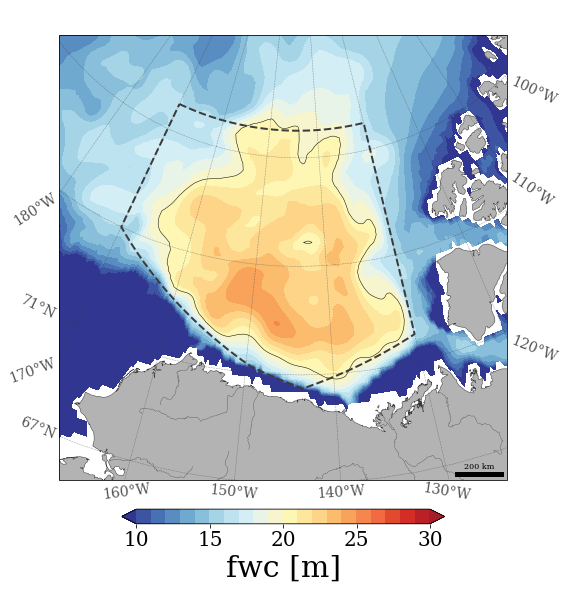

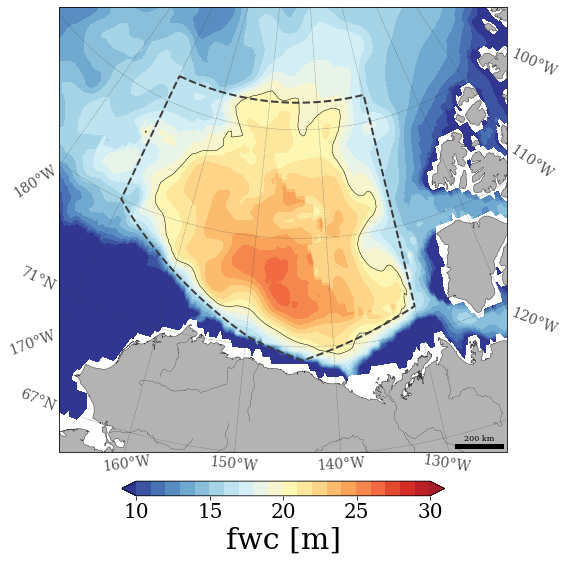

2014


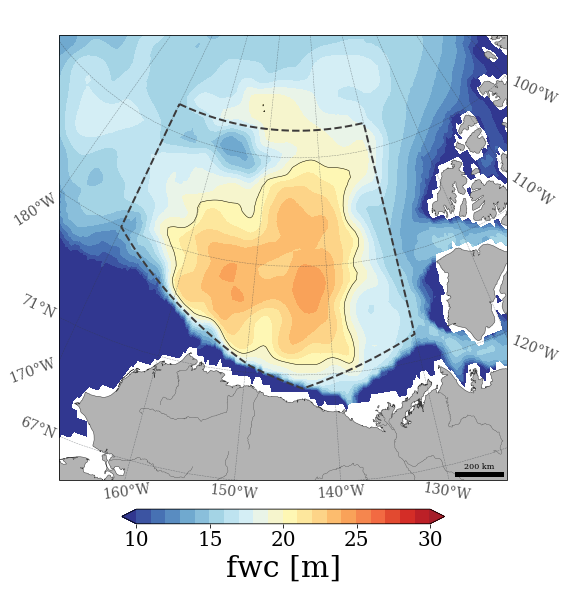

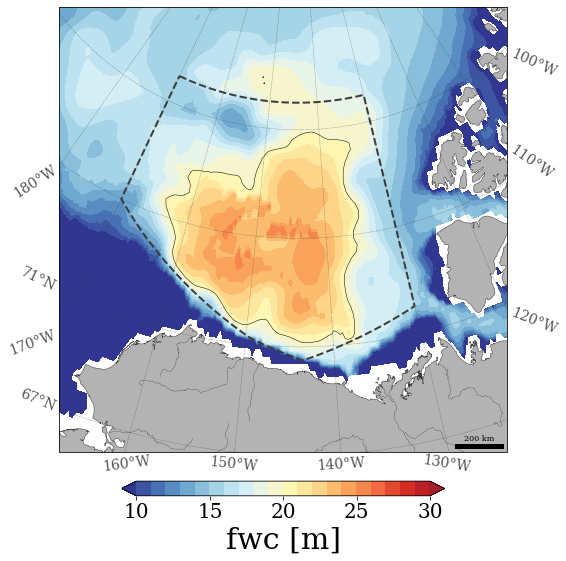

2016


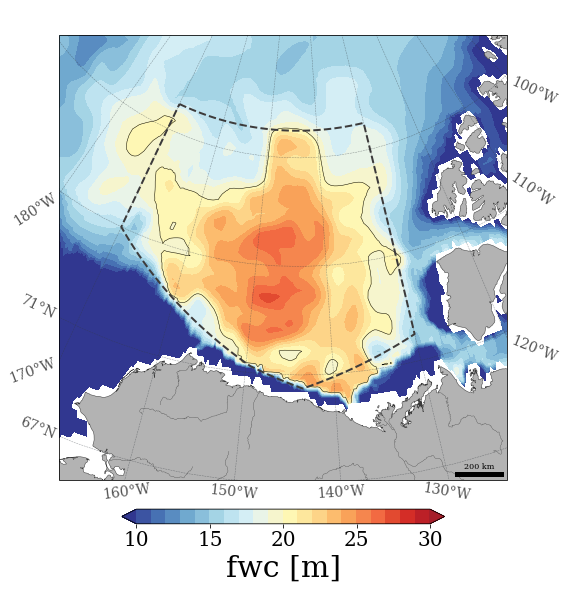

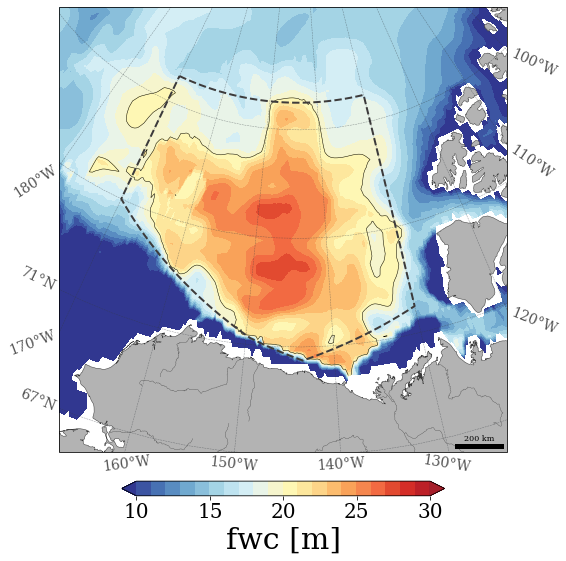

2018


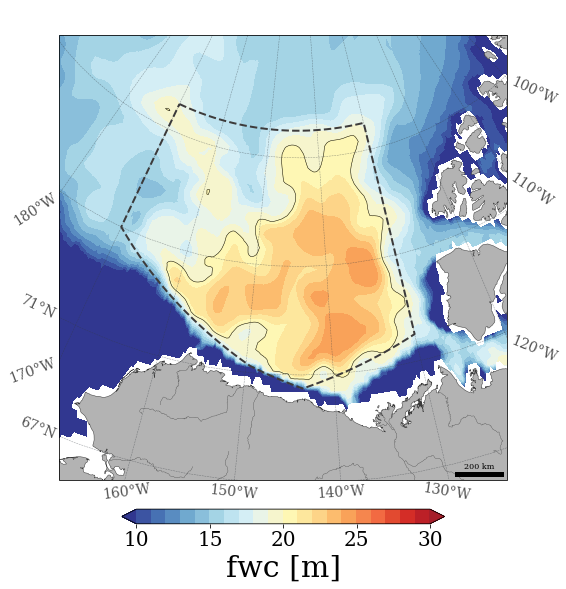

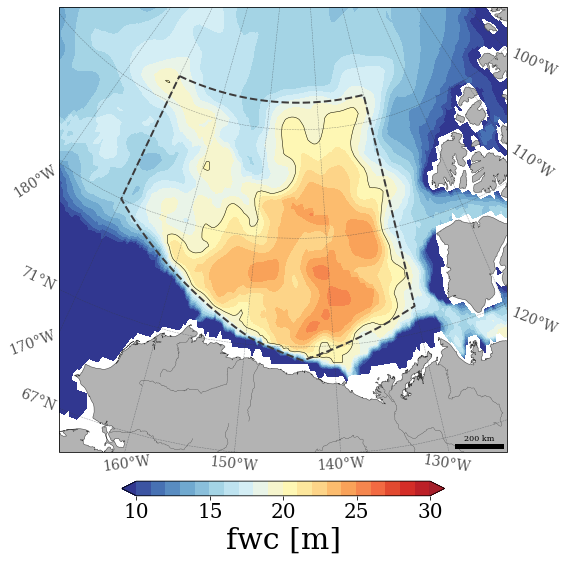

In [60]:

############################################################################
# 3. Monthly plots of selected years
############################################################################

# Subset the pre-selected month:
fwc_topaz_m_mm   = fwc_topaz_m.sel(time=fwc_topaz_m.time.dt.month.isin([month]))
fwc_topaz_km3_mm = fwc_topaz_km3.sel(time=fwc_topaz_km3.time.dt.month.isin([month]))

fwc_smos_topaz_m_mm   = fwc_smos_topaz_m.sel(time=fwc_smos_topaz_m.time.dt.month.isin([month]))

print(fwc_topaz_m_mm.shape)
print(fwc_smos_topaz_m_mm.shape)

# >> FWC [m] --------------------------------------------------------

for yy in year_selection:
    print(yy)

    # Subset year
    fwc_topaz_m_mm_yy      = fwc_topaz_m_mm.sel(time=fwc_topaz_m_mm.time.dt.year.isin([yy])).squeeze()
    fwc_smos_topaz_m_mm_yy = fwc_smos_topaz_m_mm.sel(time=fwc_smos_topaz_m_mm.time.dt.year.isin([yy])).squeeze()

    month_name = calendar.month_name[fwc_topaz_m_mm_yy.time.dt.month.values]

    dd1, llon = add_cyclic_point(fwc_topaz_m_mm_yy.values, fwc_topaz_m_mm_yy.lon)
    fwc_topaz_m_mm_yy = xr.DataArray(dd1, coords={'lat':fwc_topaz_m_mm_yy.lat, 'lon':llon}, dims=('lat','lon'))

    dd2, llon = add_cyclic_point(fwc_smos_topaz_m_mm_yy.values, fwc_smos_topaz_m_mm_yy.lon)
    fwc_smos_topaz_m_mm_yy = xr.DataArray(dd2, coords={'lat':fwc_smos_topaz_m_mm_yy.lat, 'lon':llon}, dims=('lat','lon'))

    fig = plot_arctic_mackenzie_azimuthal_poly_BG_c(darray = fwc_topaz_m_mm_yy,
                                             ptitle = ' ' ,
                                             ctitle = 'fwc [m]',
                                             minl=minl, maxl=maxl,
                                             levels=np.arange(10,31,1),
                                             cmap=cmap,
                                             blevels=bar_levels,
                                             clines=True,
                                             clevels=[20],
                                             cformat=' {:.0f} ',
                                             fs=fs)
    
#                                         ptitle = month_name +' ' + str(yy),

    if show_plots:
        plt.show()
    else:
        fig.savefig(path_save_fig+'FWC_topaz_m_'+month_name+'_'+str(yy)+'_'+version_smos_topaz+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)

    fig = plot_arctic_mackenzie_azimuthal_poly_BG_c(darray = fwc_smos_topaz_m_mm_yy,
                                             ptitle = '',
                                             ctitle = 'fwc [m]',
                                             minl=minl, maxl=maxl,
                                             levels=np.arange(10,31,1),
                                             cmap=cmap,
                                             blevels=bar_levels,
                                             clines=True,
                                             clevels=[20],
                                             cformat=' {:.0f} ',
                                             fs=fs)
    if show_plots:
        plt.show()
    else:
        fig.savefig(path_save_fig+'FWC_smos_topaz_m_'+month_name+'_'+str(yy)+'_'+version_smos_topaz+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)


2011


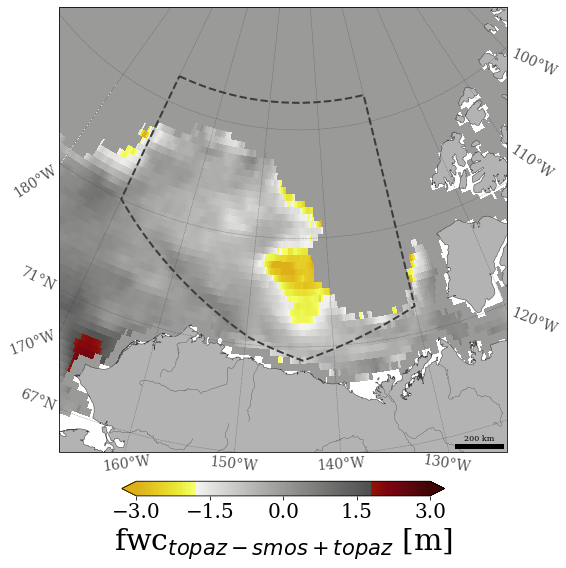

2014


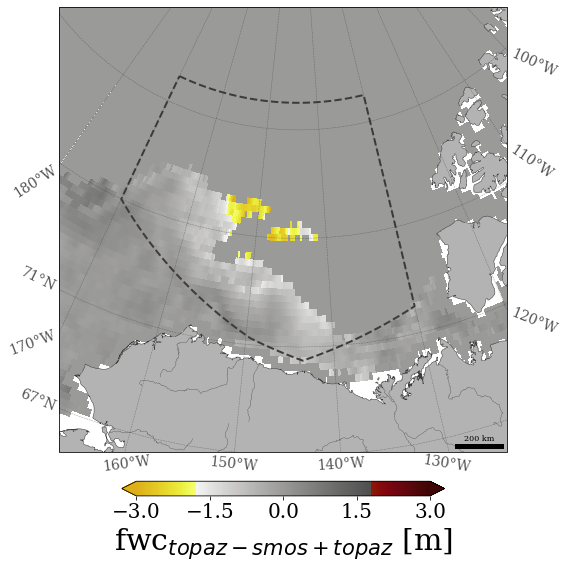

2016


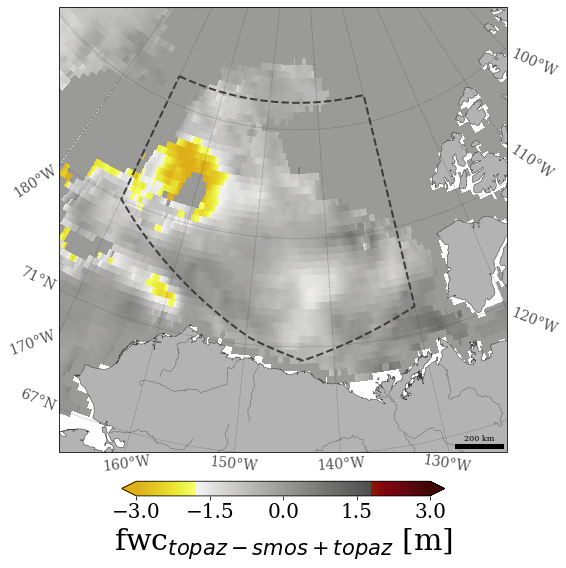

2018


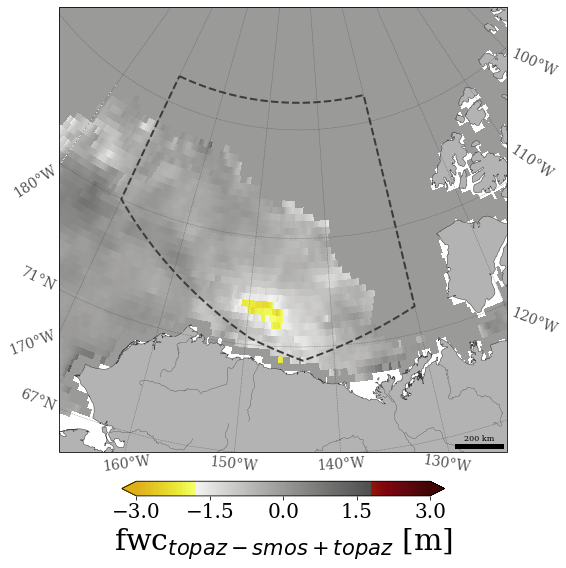

In [61]:
############################################################################
# 3. Diffence plots: Topaz4b - SMOS_Topaz4b plot
############################################################################

for yy in year_selection:
    print(yy)

    # Subset year
    fwc_topaz_m_mm_yy      = fwc_topaz_m_mm.sel(time=fwc_topaz_m_mm.time.dt.year.isin([yy])).squeeze()
    fwc_smos_topaz_m_mm_yy = fwc_smos_topaz_m_mm.sel(time=fwc_smos_topaz_m_mm.time.dt.year.isin([yy])).squeeze()

    # Calculate the difference
    diff_mm_yy = fwc_topaz_m_mm_yy - fwc_smos_topaz_m_mm_yy

    month_name = calendar.month_name[fwc_topaz_m_mm_yy.time.dt.month.values]

    # Topaz4v SSS
    fig = plot_arctic_mackenzie_azimuthal_poly_BG(darray = diff_mm_yy,
                                             ptitle = '',
                                             ctitle = 'fwc$_{topaz - smos+topaz}$ [m]',
                                             minl=minl_diff, maxl=maxl_diff,
                                             cmap=cmap_diff,
                                             blevels=levels_diff,
                                             clines=False,
                                             cformat=' {:.0f} ',
                                             fs=fs)
    if show_plots:
        plt.show()
    else:
        fig.savefig(path_save_fig+'Diff_Topaz4b_minus_SMOS_Topaz4b_FWC_'+month_name+'_'+str(yy)+'_'+version_smos_topaz+'.'+fs_format, format = fs_format, bbox_inches='tight', dpi = 300)